In [618]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats
from scipy.stats import norm

In [623]:
class QFinance:

    def compound(self, r):
        """
        returns the result of compounding the set of returns in r
        """
        return np.expm1(np.log1p(r).sum())
                         
    def annualize_rets(self, r, periods_per_year=12):
        """
        Annualizes a set of returns
        Assumes periods per year is 12 when assuming the data is monthly. If not, change periods_per_year!
        """
        compounded_growth = (1+r).prod()
        n_periods = r.shape[0]
        return compounded_growth**(periods_per_year/n_periods)-1


    def annualize_vol(self, r, periods_per_year=12):
        """
        Annualizes the vol of a set of returns
        Assumes data is monthly. If not, change periods_per_year!
        """
        return r.std()*np.sqrt(periods_per_year)


    def sharpe_ratio(self, r, riskfree = 0.0, periods_per_year=12):
        """
        Computes the annualized sharpe ratio of a set of returns
        Assumes riskfree_rate as 0.00 and periods per year is 12 when assuming the data is monthly
        If not, change periods_per_year!
        """
        # convert the annual riskfree rate to per period
        rf_per_period = (1+riskfree)**(1/periods_per_year)-1    
        
        excess_ret = r - rf_per_period
        ann_ex_ret = self.annualize_rets(excess_ret, periods_per_year)
        ann_vol = self.annualize_vol(r, periods_per_year)
        return ann_ex_ret/ann_vol
    

    def drawdown(self, return_series: pd.Series):
        """ Input should be a Pandas (time) series of asset returns.
            Function returns a DataFrame with columns for the index, the previous peaks, 
            and the percentage drawdown
        """
        wealth_index   = 1000 * (1+return_series).cumprod()
        previous_peaks = wealth_index.cummax()
        drawdowns      = (wealth_index - previous_peaks) / previous_peaks
        return pd.DataFrame({"Wealth": wealth_index,
                             "Previous Peak": previous_peaks,
                             "Drawdown": drawdowns})      
    def skewness(self, returns):
        """
        Computes the skewness of the supplied Series or DataFrame
        Input (Series of DataFrame) should be returns
        Returns a float or a Series.
        """
        return scipy.stats.skew(returns)
     
    def kurtosis(self, returns):
        """
        Computes the kurtosis of the supplied Series or DataFrame
        Input (Series of DataFrame) should be returns
        Returns a float or a Series.
        """
        return scipy.stats.kurtosis(returns, fisher=False)
    
 
    def semideviation(self, r, periods_per_year=12):
        """
        Returns the semideviation aka negative semideviation of r.
        r must be a Series or a DataFrame, else raises a TypeError
        """
        if isinstance(r, pd.Series):
            is_negative = r < 0
            return r[r<0].std(ddof=0)*np.sqrt(periods_per_year)
        elif isinstance(r, pd.DataFrame):
            return r.aggregate(self.semideviation)
        else:
            raise TypeError("Expected r to be a Series or DataFrame")
            
    def sortino_ratio(self, r, riskfree = 0.0, periods_per_year=12):
        """
        Computes the annualized sortino ratio of a set of returns
        Assumes riskfree_rate as 0.00 and periods per year is 12 when assuming the data is monthly
        If not, change periods_per_year!
        """
        
        # convert the annual riskfree rate to per period
        rf_per_period = (1+riskfree)**(1/periods_per_year)-1    
        
        excess_ret = r - rf_per_period
        ann_ex_ret = self.annualize_rets(excess_ret, periods_per_year)
        ann_vol = self.semideviation(r, periods_per_year)
        return ann_ex_ret/ann_vol
    
        
    def cvar_historic(self, r, level=5):
        """
        Computes the Conditional VaR of Series or DataFrame
        """
        if isinstance(r, pd.Series):
            is_beyond = (r <= -self.var_historic(r, level=level))
            return -r[is_beyond].mean()
        elif isinstance(r, pd.DataFrame):
            return r.aggregate(self.cvar_historic, level=level)
        else:
            raise TypeError("Expected r to be a Series or DataFrame")
   
    def var_historic(self, r, level=5):
        """
        Returns the historic Value at Risk at a specified level
        i.e. returns the number such that "level" percent of the returns
        fall below that number, and the (100-level) percent are above
        """
        if isinstance(r, pd.DataFrame):
            return r.aggregate(self.var_historic, level=level)
        elif isinstance(r, pd.Series):
            return -np.percentile(r, level)
        else:
            raise TypeError("Expected r to be a Series or DataFrame")

    def var_gaussian(self, r, level=5, modified=False):
        """
        Returns the Parametric Gaussian VaR of a Series or DataFrame
        If "modified" is True, then the modified VaR is returned,
        using the Cornish-Fisher modification
        """
        # compute the Z score assuming it was Gaussian
        z = norm.ppf(level/100)
        if modified: #Cornish-Fisher VaR
            # modify the Z score based on observed skewness and kurtosis
            s = self.skewness(r)
            k = self.kurtosis(r)
            z = (z +
                    (z**2 - 1)*s/6 +
                    (z**3 -3*z)*(k-3)/24 -
                    (2*z**3 - 5*z)*(s**2)/36
                )
        return -(r.mean() + z*r.std(ddof=0))
        
  
    def var_compare(self, r, level = 5):
        var_list   = [self.var_gaussian(r, level=level), self.var_gaussian(r, level=level, modified=True), self.var_historic(r, level=level),
                      self.cvar_historic(r, level=level)]
        comparison = pd.concat(var_list, axis=1)
        comparison.columns = ['Gaussian VaR', 'Cornish-Fisher VaR', 'Historic VaR', 'CVaR']
        comparison.plot.bar(title = 'VaR with cutoff level: %spct' % level, figsize = (10,6))
        return comparison
    
    def summary_stats(self, r, riskfree=0.00, periods_per_year=12):
        """
        Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
        """
        ann_r = r.aggregate(self.annualize_rets, periods_per_year=periods_per_year)
        ann_vol = r.aggregate(self.annualize_vol, periods_per_year=periods_per_year)
        ann_sr = r.aggregate(self.sharpe_ratio, riskfree=riskfree, periods_per_year=periods_per_year)
        dd = r.aggregate(lambda r: self.drawdown(r).Drawdown.min())
        skew = r.aggregate(self.skewness)
        kurt = r.aggregate(self.kurtosis)
        cf_var5 = r.aggregate(self.var_gaussian, level =5, modified=True)
        hist_cvar5 = r.aggregate(self.cvar_historic, level =5)
        hist_cvar5 = r.aggregate(self.cvar_historic, level =5)
        sort = r.aggregate(self.sortino_ratio, riskfree=riskfree, periods_per_year=periods_per_year)
        smd = r.aggregate(self.semideviation, periods_per_year=periods_per_year)
        
        return pd.DataFrame({
            "Annualized Return": ann_r,
            "Annualized Vol": ann_vol,
            "Skewness": skew,
            "Kurtosis": kurt,
            "Cornish-Fisher VaR (5%)": cf_var5,
            "Historic CVaR (5%)": hist_cvar5,
            "Sharpe Ratio": ann_sr,
            "Max Drawdown": dd,
            "Sortino Ratio": sort,
            "Semideviation":smd
        })

In [644]:
file = '/users/eyupgulsun/desktop/Equity Funds Data.xlsx'
df = pd.read_excel(file, index_col=0, parse_dates=True)
Q = QFinance()

In [645]:
df_pctchg= df.pct_change().dropna()
data=Q.summary_stats(df_pctchg, periods_per_year=252)
data.sort_values(by = ['Annualized Return'], ascending = False).head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown,Sortino Ratio,Semideviation
MAC,2.458696,0.255689,-0.089994,4.466255,0.021201,0.031663,9.615961,-0.103810,13.703774,0.179417
OPH,2.178755,0.249055,-0.455888,3.519371,0.022723,0.031225,8.748076,-0.109656,12.967901,0.168011
TKF,2.168348,0.208971,0.000620,5.113645,0.016288,0.025391,10.376304,-0.066383,14.502541,0.149515
TI3,2.109103,0.264497,-0.084057,3.514054,0.022812,0.030687,7.974024,-0.056061,12.990825,0.162353
ADP,1.749813,0.388370,0.637238,4.502473,0.030354,0.044612,4.505527,-0.094379,8.129257,0.215249


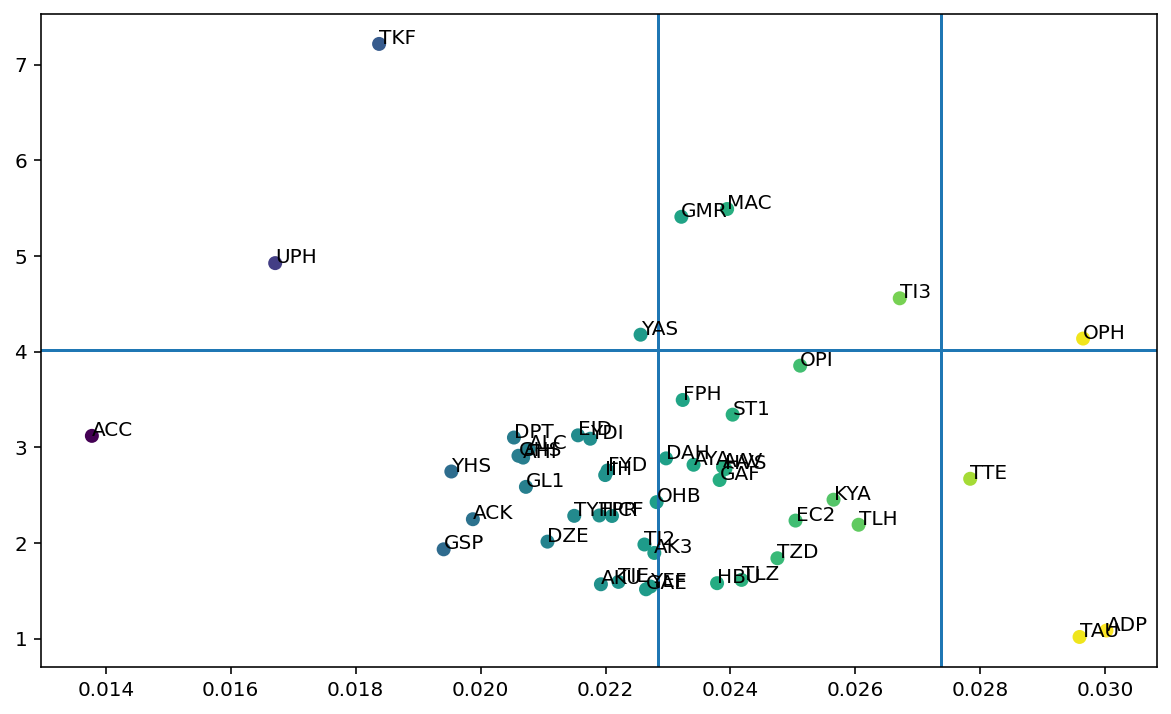

In [802]:
a1 = Q.summary_stats(df_6months, periods_per_year=252)
x=a1['Cornish-Fisher VaR (5%)']
y= a1['Sharpe Ratio']
plt.figure(figsize = (10, 6))
plt.scatter(x=x, y= y, c = a1['Cornish-Fisher VaR (5%)'])
#plt.axvline(x.quantile(0.95))
plt.axvline(x.mean())
plt.axvline(x.mean()+1.50*x.std())
plt.axhline(y.mean() + y.std())
#CLUSTERING MACHINE LEARNING!!!!
#BENCE EN IYI MODEL BU
for i, txt in enumerate(a1.index.to_list()):
    plt.annotate(txt, (x[i], y[i]))

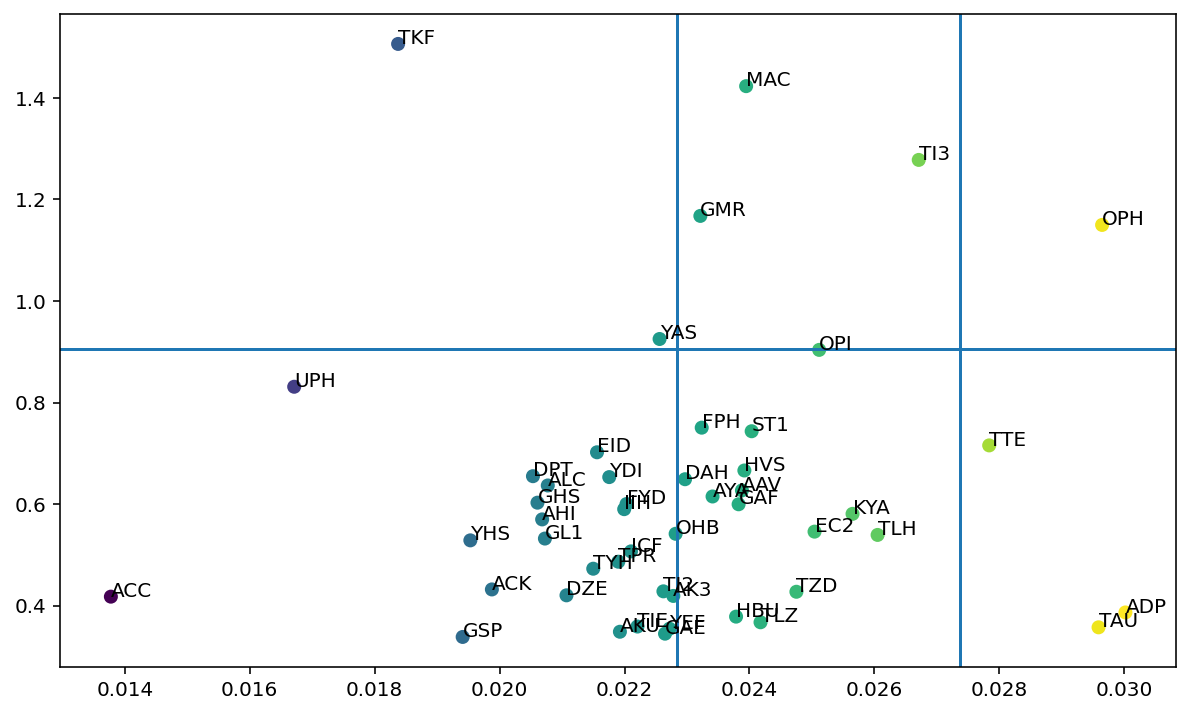

In [801]:
x=a1['Cornish-Fisher VaR (5%)']
y= a1['Annualized Return']
plt.figure(figsize = (10, 6))
plt.scatter(x=x, y= y, c = a1['Cornish-Fisher VaR (5%)'])
#plt.axvline(x.quantile(0.95))
plt.axvline(x.mean())
plt.axvline(x.mean()+1.50*x.std())
plt.axhline(y.mean() + y.std())
#CLUSTERING MACHINE LEARNING!!!!
for i, txt in enumerate(a1.index.to_list()):
    plt.annotate(txt, (x[i], y[i]))

In [693]:
# for i in data.columns:
#     plt.boxplot(data[i])
#     print(i)
#     plt.show()

In [785]:
# sns.pairplot(data)

In [684]:
df_3years = df['2017':].dropna(axis = 'columns').pct_change().dropna()
df_2years = df['2019':].dropna(axis = 'columns').pct_change().dropna()
df_1years = df['2020':].dropna(axis = 'columns').pct_change().dropna()
df_6months = df['2020-06-01':].dropna(axis = 'columns').pct_change().dropna()
df_3months = df['2019-09-01':].dropna(axis = 'columns').pct_change().dropna()
df_1months = df['2019-10-01':].dropna(axis = 'columns').pct_change().dropna()

In [705]:
def filters(data, return_filter = 0.75, sharpe_ratio_filter = 0.15, semideviation_filter = 0.85, cf_var_filter = 0.85):
    Q = QFinance()
    
    filter1=Q.summary_stats(data, periods_per_year=252)

#     md_limit = filter1['Max Drawdown'].quantile(max_dd_filter)
#     filter1 = filter1[filter1['Max Drawdown']>=md_limit]

    cfvar_limit = filter1['Cornish-Fisher VaR (5%)'].quantile(cf_var_filter)
    filter2 = filter1[filter1['Cornish-Fisher VaR (5%)']<=cfvar_limit]
#    print('filter2', filter2.count())

    sr_limit = filter1['Semideviation'].quantile(semideviation_filter)
    filter3 = filter2[filter2['Semideviation']<=sr_limit]
 #   print('filter3', filter3.count())
    
    sh_limit = filter1['Sharpe Ratio'].quantile(sharpe_ratio_filter)
    filter4 = filter3[filter3['Sharpe Ratio']>=sh_limit]
  #  print('filter4', filter4.count())
    
    avg_limit = filter1['Annualized Return'].quantile(return_filter)
    filter5 = filter4[filter4['Annualized Return']>=avg_limit]
   # print('filter5', filter5.count())
    
#     avg_limit = filter1['Annualized Return'].mean()
#     filter1 = filter1[filter1['Annualized Return']>=avg_limit]

    return filter5.sort_values(by=['Annualized Return'], ascending=False)

In [803]:
filters(df_1years)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown,Sortino Ratio,Semideviation
FPH,0.533499,0.268532,-1.059203,6.524005,0.029447,0.046277,1.986721,-0.297542,2.179471,0.244784
EID,0.523283,0.260306,-0.936868,7.206748,0.027805,0.041140,2.010258,-0.267685,2.319057,0.225645
GL1,0.425638,0.253040,-0.664734,6.177691,0.026480,0.040485,1.682097,-0.268867,1.983997,0.214536
UPH,0.389130,0.233564,-1.089197,8.377490,0.025359,0.038570,1.666055,-0.282100,1.855890,0.209673
YDI,0.383114,0.255920,-0.893316,6.176970,0.027853,0.042107,1.497009,-0.300513,1.708907,0.224187
